## Accessing Deltares global water availability on Azure

[Deltares](https://www.deltares.nl/en/) has produced a hydrological model approach to simulate historical daily reservoir variations for 3,236 locations across the globe for the period 1970-2020 using the distributed [wflow_sbm](https://deltares.github.io/Wflow.jl/stable/model_docs/model_configurations/) model. The model outputs long-term daily information on reservoir volume, inflow and outflow dynamics, as well as information on upstream hydrological forcing.

They hydrological model was forced with 5 different precipitation products. Two products (ERA5 and CHIRPS) are available at the global scale, while for Europe, USA and Australia a regional product was use (i.e. EOBS, NLDAS and BOM, respectively). Using these different precipitation products, it becomes possible to assess the impact of uncertainty in the model forcing. A different number of basins upstream of reservoirs are simulated, given the spatial coverage of each precipitation product.

### Environment setup

In [1]:
import warnings

warnings.simplefilter("ignore")

import fsspec
import matplotlib.pyplot as plt
import xarray as xr
import pystac_client
import planetary_computer
import requests
import geopandas
import contextily
import dask.distributed

### Create a local Dask cluster

Enable parallel reads and processing of data using Dask and xarray.

In [2]:
client = dask.distributed.Client(processes=False)
print(client.dashboard_link)

/user/taugspurger@microsoft.com/proxy/39497/status


### Data access

The collection is made up of five netCDF files, each corresponding to a different precipitation product for hydrological model forcing. Each variation covers a different spatial extent, with different number of reservoirs modeled. We'll choose one of the smaller files using a [BOM](http://www.bom.gov.au/) dataset covering Australia here. The `delatres:reservoir` key can be used to filter to a specific dataset.

The other files available from the same root store are `CHIRPS`, `EOBS`, `ERA5`, and `NLDAS`.

We'll open the dataset and look at the variables and dimensions it contains.

In [3]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace    
)

In [4]:
item = (
    catalog.get_collection("deltares-water-availability")
    .get_item("BOM")
)
item

<Item id=BOM>

Each item has two assets: `data` pointing to the NetCDF file, and `index` pointing to an index file enabling cloud-optimzed access. When accessing the data from Azure, we recommend using the index file.

In [5]:
index = planetary_computer.sign(requests.get(item.assets["index"].href).json())

store = fsspec.get_mapper("reference://", fo=index)

ds = xr.open_dataset(store, engine="zarr", consolidated=False, chunks={})
ds

<xarray.Dataset>
Dimensions:      (time: 14245, GrandID: 116, ksathorfrac: 5)
Coordinates:
  * GrandID      (GrandID) float64 6.675e+03 6.666e+03 ... 6.594e+03 6.706e+03
  * ksathorfrac  (ksathorfrac) float64 5.0 20.0 50.0 100.0 250.0
  * time         (time) datetime64[ns] 1982-01-01 1982-01-02 ... 2020-12-31
Data variables: (12/14)
    ETa          (time, GrandID, ksathorfrac) float32 dask.array<chunksize=(1, 116, 5), meta=np.ndarray>
    Ea_res       (time, GrandID, ksathorfrac) float32 dask.array<chunksize=(1, 116, 5), meta=np.ndarray>
    FracFull     (time, GrandID, ksathorfrac) float32 dask.array<chunksize=(1, 116, 5), meta=np.ndarray>
    Melt         (time, GrandID, ksathorfrac) float32 dask.array<chunksize=(1, 116, 5), meta=np.ndarray>
    P            (time, GrandID, ksathorfrac) float32 dask.array<chunksize=(1, 116, 5), meta=np.ndarray>
    PET          (time, GrandID, ksathorfrac) float32 dask.array<chunksize=(1, 116, 5), meta=np.ndarray>
    ...           ...
    Qout_res     (time, GrandID, ksathorfrac) float32 dask.array<chunksize=(1, 116, 5), meta=np.ndarray>
    S_res        (time, GrandID, ksathorfrac) float32 dask.array<chunksize=(1, 116, 5), meta=np.ndarray>
    Snow         (time, GrandID, ksathorfrac) float32 dask.array<chunksize=(1, 116, 5), meta=np.ndarray>
    Temp         (time, GrandID, ksathorfrac) float32 dask.array<chunksize=(1, 116, 5), meta=np.ndarray>
    latitude     (GrandID) float32 dask.array<chunksize=(116,), meta=np.ndarray>
    longitude    (GrandID) float32 dask.array<chunksize=(116,), meta=np.ndarray>

### Inspect the reservoirs

First, we'll plot a simple map of where all the modeled reservoirs are located in Australia.

In [6]:
# Just interested in the GrandID dimension
df = ds.drop_dims(["time", "ksathorfrac"]).to_pandas()

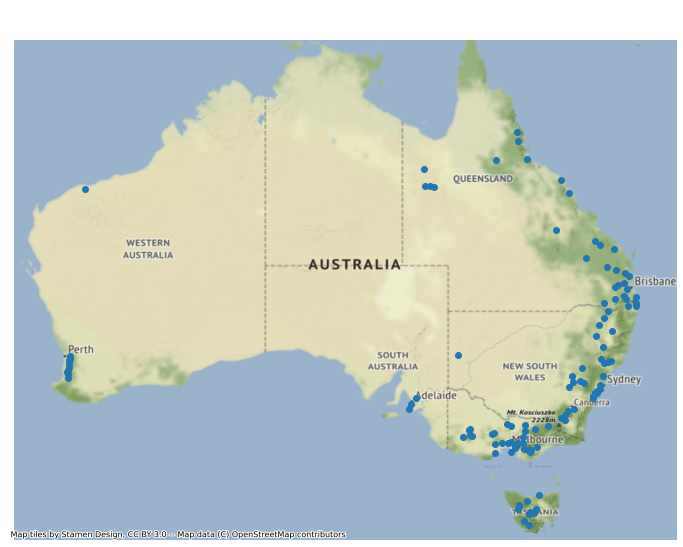

In [7]:
geometry = geopandas.GeoSeries(
    geopandas.points_from_xy(df.longitude, df.latitude), crs="WGS84"
)
ax = geometry.plot(figsize=(12, 12))
contextily.add_basemap(ax, crs=geometry.crs.to_string())

ax.set_axis_off()
ax.set(ylim=(-44, -9), xlim=(112, 156));

#### Mean precipitation upstream of all reservoirs, single year

Now we'll pluck a single year in the series and plot the mean precipitation upstream of all the reservoir basins.

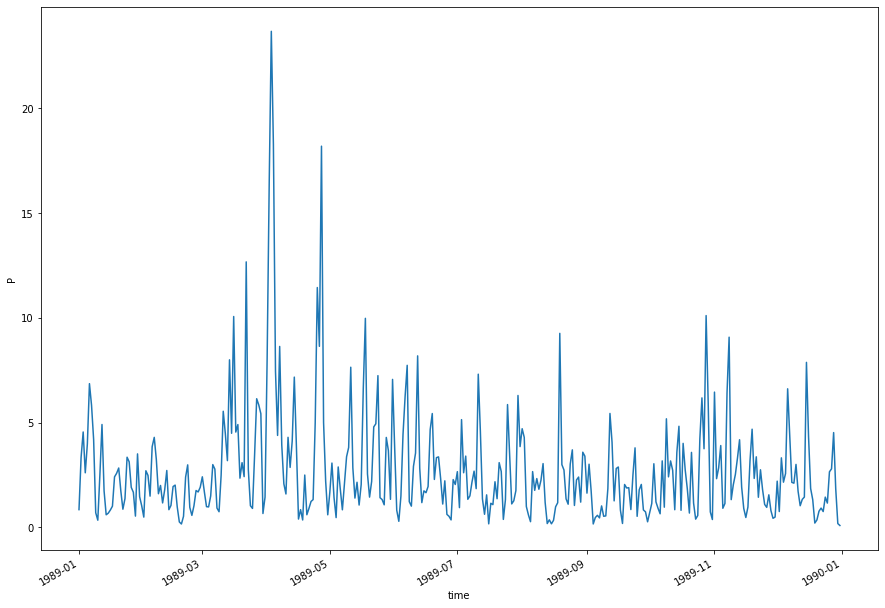

In [8]:
precip_yr = ds.P.sel(time="1989")
g = precip_yr.groupby("time")
p = g.mean(...).plot(figsize=(15, 10))

### Inspect a single reservoir

We'll select the first reservoir by Id and a [KsatHorFrac](https://wflow.readthedocs.io/en/latest/wflow_sbm.html) of `50`. To get a sense of how the volume of water in the reservoir changes seasonally, let's plot the fraction of the reservoir that's full by month over the full time series.

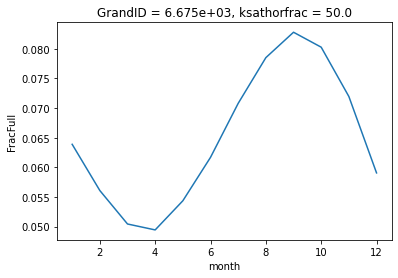

In [9]:
single_res = ds.sel(GrandID=ds.GrandID[0], ksathorfrac=50)
p = single_res.FracFull.groupby("time.month").mean().plot()

We can also check the volume directly over the course of the time series. This reservoir shows a sharp decrease in volume over time, according to the model.

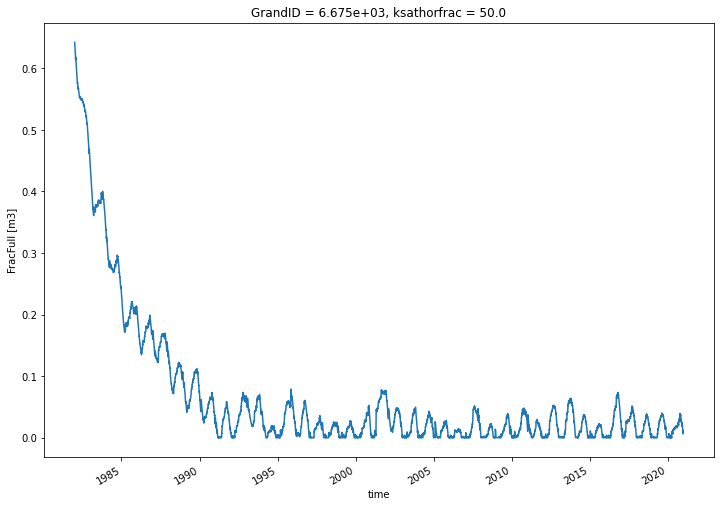

In [10]:
p = single_res.FracFull.plot(figsize=(12, 8))

We can also plot other variables, daily, over the course of a single year.

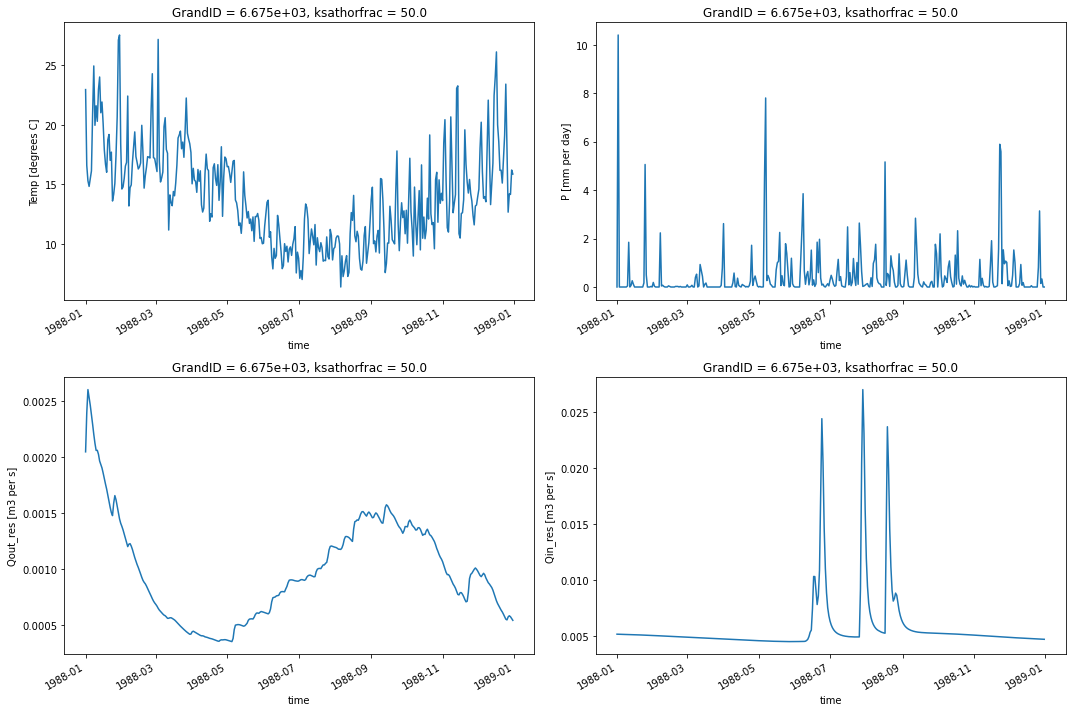

In [11]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(15, 10))

year = single_res.sel(time="1988")

year.Temp.plot(ax=axes[0][0])
year.P.plot(ax=axes[0][1])
year.Qout_res.plot(ax=axes[1][0])
year.Qin_res.plot(ax=axes[1][1])

plt.tight_layout()
plt.draw()

### Observe the impact of KsatHorFrac

Here we'll select a new reservoir and plot how the different `KsatHorFrac` values affect volume in the model.

In [ ]:
single_res_ksats = ds.sel(GrandID=6662).groupby("time.year").mean()
p = single_res_ksats.FracFull.plot.line(figsize=(12, 8), hue="ksathorfrac", x="year")

### Inspect all reservoirs

We can also plot out all the reservoirs' `FracFull` variable and see how the different `KsatHorFrac` values affect volume in the model.

In [ ]:
y = ds.FracFull.groupby("time.year").mean().compute()
p = y.plot.line(col="GrandID", x="year", col_wrap=6)